In [1]:
import MDAnalysis as mda
import numpy as np
import matplotlib.pyplot as plt
from MDAnalysis.analysis import align
from scipy.ndimage import gaussian_filter1d

uA = mda.Universe("protein.pdb", "5us_protein_only_center.xtc")
uB = mda.Universe("protein.pdb", "only_prot_center.xtc")

def align_trajectory(universe, top_file, traj_file, reference=None, selection="name BB", in_memory=True):
    if reference is None:
        reference = mda.Universe(top_file, traj_file)
        reference.trajectory[0]  # first frame

    aligner = align.AlignTraj(universe, reference, select=selection, in_memory=in_memory)
    aligner.run()

    return universe

uA = align_trajectory(uA,"protein.pdb", "5us_protein_only_center.xtc", selection="name BB")
uB = align_trajectory(uB,"protein.pdb", "only_prot_center.xtc", selection="name BB")

C:\Users\jitde\AppData\Local\Programs\Python\Python311\Lib\site-packages\MDAnalysis\topology\PDBParser.py:350: UserWarning: Element information is missing, elements attribute will not be populated. If needed these can be guessed using universe.guess_TopologyAttrs(context='default', to_guess=['elements']).
  warnings.warn("Element information is missing, elements attribute "


In [2]:
def compute_displacement_mean(u, selection, stride=1000):
    displacements = []
    # Save reference positions from the first frame
    u.trajectory[0]  # go to first frame
    ref_pos = selection.positions.copy()
    
    for ts in u.trajectory[::stride]:
        curr_pos = selection.positions.copy()
        diff = np.linalg.norm(curr_pos - ref_pos, axis=1)  # per-atom displacement
        avg_disp = np.mean(diff)
        displacements.append(avg_disp)
        
    return displacements

def compute_displacement_median(u, selection, stride=1000):
    displacements = []
    # Save reference positions from the first frame
    u.trajectory[0]  # go to first frame
    ref_pos = selection.positions.copy()
    
    for ts in u.trajectory[::stride]:
        curr_pos = selection.positions.copy()
        diff = np.linalg.norm(curr_pos - ref_pos, axis=1)
        avg_disp = np.median(diff)
        displacements.append(avg_disp)
        
    return displacements

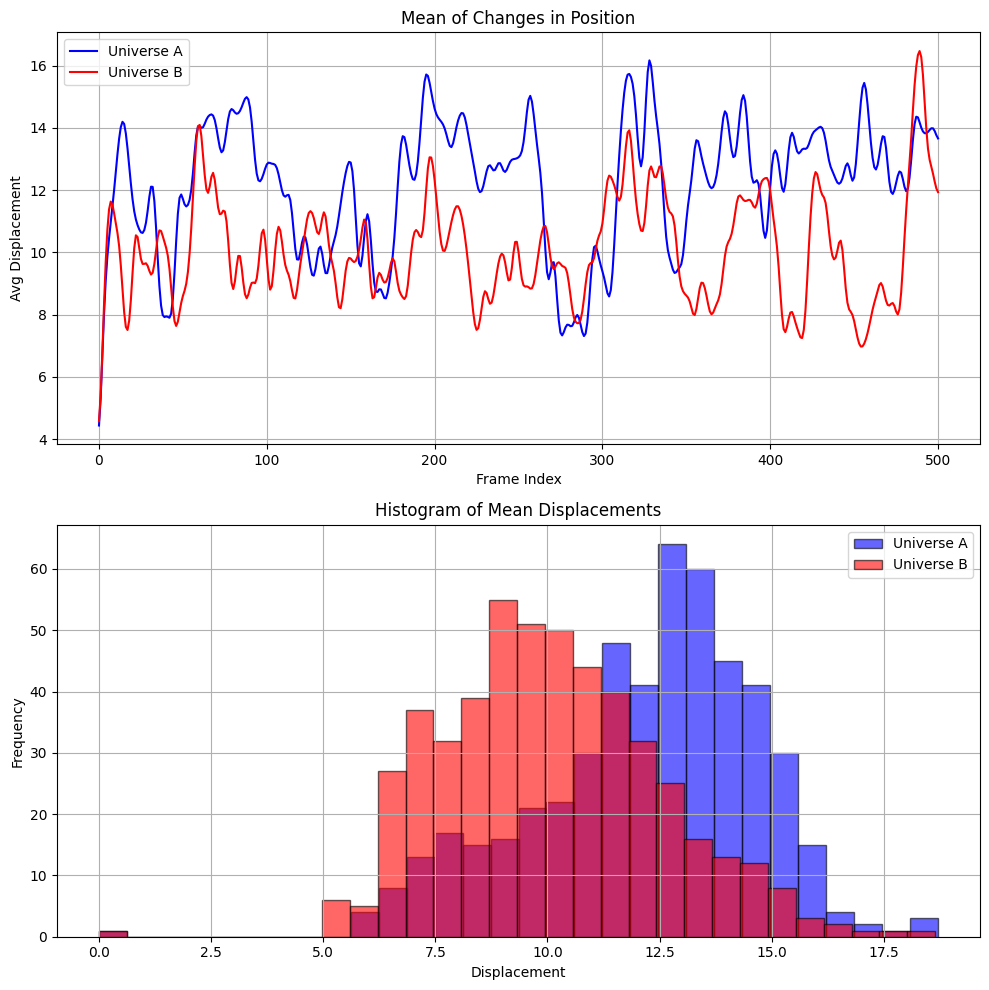

In [3]:
disp_A = compute_displacement_mean(uA, uA.select_atoms("all"), stride=100)
disp_B = compute_displacement_mean(uB, uB.select_atoms("all"), stride=100)

# Assuming disp_A and disp_B are computed using compute_displacement_mean
smooth_A = gaussian_filter1d(disp_A, sigma=2)
smooth_B = gaussian_filter1d(disp_B, sigma=2)

x = np.arange(len(smooth_A))

fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# 1. Line plot of smoothed mean displacement
axs[0].plot(x, smooth_A, label="Universe A", color='blue')
axs[0].plot(x, smooth_B, label="Universe B", color='red')
axs[0].set_xlabel("Frame Index")
axs[0].set_ylabel("Avg Displacement")
axs[0].set_title("Mean of Changes in Position")
axs[0].legend()
axs[0].grid(True)

# 2. Histogram of raw (unsmoothed) mean displacements
axs[1].hist(disp_A, bins=30, alpha=0.6, label="Universe A", color='blue', edgecolor='black')
axs[1].hist(disp_B, bins=30, alpha=0.6, label="Universe B", color='red', edgecolor='black')
axs[1].set_xlabel("Displacement")
axs[1].set_ylabel("Frequency")
axs[1].set_title("Histogram of Mean Displacements")
axs[1].legend()
axs[1].grid(True)

plt.tight_layout()
plt.show()

In [4]:
# disp_A = compute_displacement_median(uA, uA.select_atoms("all"), stride=1)
# disp_B = compute_displacement_median(uB, uB.select_atoms("all"), stride=1)

# smooth_A = gaussian_filter1d(disp_A, sigma=2)
# smooth_B = gaussian_filter1d(disp_B, sigma=2)

# x = np.arange(len(disp_A))

# # Create subplots
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # Line plot of smoothed displacement
# axs[0].plot(x, smooth_A, label="Universe A", color='blue')
# axs[0].plot(x, smooth_B, label="Universe B", color='red')
# axs[0].set_xlabel("Frame Index")
# axs[0].set_ylabel("Normalized Avg Displacement")
# axs[0].set_title("Median of Changes in Position (Smoothed)")
# axs[0].legend()
# axs[0].grid(True)

# # Histogram plot
# axs[1].hist(disp_A, bins=30, alpha=0.6, label="Universe A", color='blue', edgecolor='black')
# axs[1].hist(disp_B, bins=30, alpha=0.6, label="Universe B", color='red', edgecolor='black')
# axs[1].set_xlabel("Displacement")
# axs[1].set_ylabel("Frequency")
# axs[1].set_title("Histogram of Displacements")
# axs[1].legend()
# axs[1].grid(True)

# plt.tight_layout()
# plt.show()

In [5]:
a = np.array(disp_A)
mean_disp_A = np.mean(a)
print("mean:", mean_disp_A)

closest_index = np.argmin(np.abs(a - mean_disp_A))
print("Index of closest value:", closest_index)

uA.trajectory[closest_index]
with mda.Writer(f"frame_{closest_index}_uA.pdb") as W:
    W.write(uA.atoms)

mean: 12.191318
Index of closest value: 94


C:\Users\jitde\AppData\Local\Programs\Python\Python311\Lib\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'elements' Using default value of ' '
  warnings.warn("Found no information for attr: '{}'"
C:\Users\jitde\AppData\Local\Programs\Python\Python311\Lib\site-packages\MDAnalysis\coordinates\PDB.py:1154: UserWarning: Found no information for attr: 'formalcharges' Using default value of '0'
  warnings.warn("Found no information for attr: '{}'"
C:\Users\jitde\AppData\Local\Programs\Python\Python311\Lib\site-packages\MDAnalysis\coordinates\PDB.py:1201: UserWarning: Found missing chainIDs. Corresponding atoms will use value of 'X'
  warnings.warn("Found missing chainIDs."


In [6]:
b = np.array(disp_B)
mean_disp_B = np.mean(b)
print("mean:", mean_disp_B)

closest_index = np.argmin(np.abs(b - mean_disp_B))
print("Index of closest value:", closest_index)

uB.trajectory[closest_index]
with mda.Writer(f"frame_{closest_index}_uB.pdb") as W:
    W.write(uB.atoms)

mean: 10.08372
Index of closest value: 248
